## Integrate L-Py with xarray-simlab

https://xarray-simlab.readthedocs.io

### Write Lpy file and save it

In [1]:
%%writefile .devel.lpy

import matplotlib.pyplot as plt
import matplotlib as mpl

color = plt.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=nb_metamers), cmap=plt.cm.hsv)

#################################

from numpy import exp, linspace
growth_logistic = lambda ttime, fsize: fsize / (1. + exp(-(ttime-5)/1.5 ))

#################################

extern(flush_delay = None)
extern(nb_metamers = None)
extern(step_delta = None)

#################################

module Metamer(t,leaf_size,internode_size)
module Apex(t)

#################################

Axiom:  R Apex(ApexParams(t=0))

derivation length: 1
production:

Apex(p) :
    if (p.t % flush_delay) < step_delta and (p.t // flush_delay) < nb_metamers:  
        nproduce Metamer(MetamerParams(t=0, leaf_size=0, internode_size=0))
    produce Apex(p.set(t=p.t+step_delta))

Metamer(p):
    p.t += step_delta
    p.leaf_size = growth_logistic(p.t, 10)
    p.internode_size = growth_logistic(p.t,3)
    produce Metamer(p)
    
interpretation:

R --> _(0.3)@Gc SetColor(Material('green',(1,15,1),diffuse=10,specular=(0,0,0)))

Metamer(p) :
    l = p.leaf_size
    r, g, b, a = map(lambda v : int(v*255), color.to_rgba(p.uid))
    nproduce F(p.internode_size) /(137)[SetColor(r, g, b)_(0.1)&(min(80,float(p.t)*5))F(l/6)[+(90)/(-30)~l(l/2)][-(90)/(30)~l(l/2)]F(l/6)[+(60)/(-15)~l(l/2)][-(60)/(15)~l(l/2)]F(l/6)^(20)~l(l/2)]

Apex(p) --> F(1) @O


Overwriting .devel.lpy


### Create an xarray-simlab processes from an Lpy model

* __LpyDevel__, build lstring and scene and access computed variables 

### Create xarray-simlab model and simulation setup with the two processes

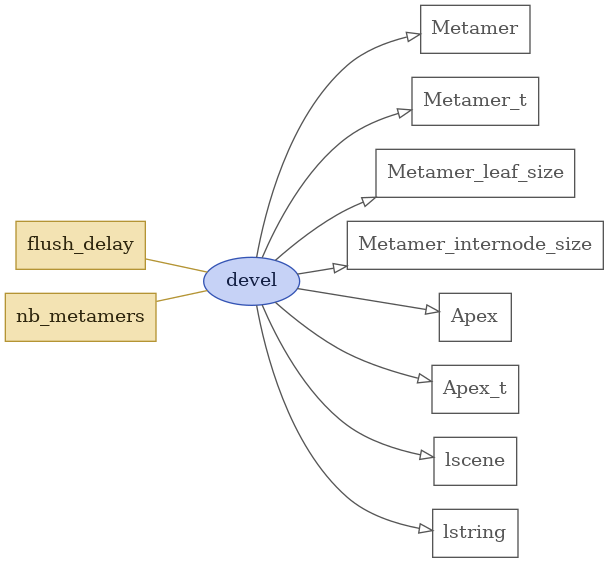

In [2]:
import xsimlab as xs
from lpy_simlab_process import xs_lpyprocess
import numpy as np

model = xs.Model({ 'devel': xs_lpyprocess('LpyDevel', '.devel.lpy') })
ds = xs.create_setup(
    model=model,
    clocks={ 'time': np.linspace(0, 25, 250) },
    input_vars={ 'devel': { 'flush_delay' : 4, 'nb_metamers' : 5 } },
    output_vars={
        'devel__Metamer_leaf_size': 'time',
        'devel__Metamer_internode_size': 'time',
        'devel__Apex_t': 'time',
    }
)
model.visualize(show_inputs=True, show_variables=True)

### Run the model and inspect results

In [4]:
from lpy_simlab_process import xs_lpydisplay_hook

ds_out = ds.xsimlab.run(model=model, hooks=xs_lpydisplay_hook('devel', scale = 1/30))
ds_out

SceneWidget(scenes=[{'id': 'GiIoPjE1AsHamDH74vKnJuO6K', 'data': b'x\xdaSLrw\xf5\xf7e`Pp\xe0\xe5RPVVd\x00\x020\…

             0% | initialize 

<xarray.Dataset>
Dimensions:                        (Apex: 1, Metamer: 5, time: 250)
Coordinates:
  * Apex                           (Apex) float64 0.0
  * Metamer                        (Metamer) float64 0.0 1.0 2.0 3.0 4.0
  * time                           (time) float64 0.0 0.1004 ... 24.9 25.0
Data variables:
    devel__Apex_t                  (time, Apex) float64 0.1004 0.2008 ... 25.0
    devel__Metamer_internode_size  (time, Metamer) float64 nan nan ... 2.784
    devel__Metamer_leaf_size       (time, Metamer) float64 nan nan ... 9.28
    devel__flush_delay             int64 4
    devel__nb_metamers             int64 5

### Plot output

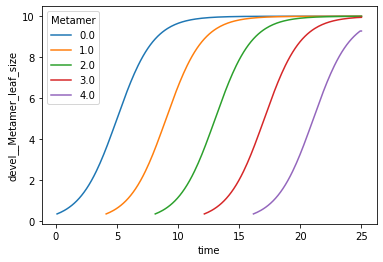

In [5]:
ds_out.devel__Metamer_leaf_size.plot.line(x='time');